# A drug discovery problem: Can we predict antimicrobial activity?

In this notebook, we will explore a drug discovery problem based on antimicrobial peptides (AMPs). The notebook will use well known examples to facilitate the introduction of python packages and scientific methods.

Antimicrobial peptides are short sequences of amino acids that can kill a variety of microbes. Their antimicrobial power is usually quantified in terms of MIC (Minimum Inhibitory Concentration), that is, the smallest concentration at which the peptide can inhibit growth of microbial cells.

We will use data retreived from a public database called DBAASP, and will use free software to explore the physicochemical properties of peptides, and attempt to model their activity.

## Preamble

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os

In [2]:
from Toolkit.toolkit import *

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"]=6,4
plt.rcParams['figure.dpi'] = 300

## Load and prepare data

In [6]:
# Load the CSV file into memory by creating a Pandas DataFrame.

ampRawDF = pd.read_csv(os.path.join("Datasets","peptides.csv"))
ampRawDF.head()

,ID,COMPLEXITY,NAME,N TERMINUS,SEQUENCE,C TERMINUS,SYNTHESIS TYPE,TARGET GROUP,TARGET OBJECT
0,8,Monomer,NaN,C16,KVvvKWVvKvVK,AMD,Synthetic,NaN,NaN
1,12,Monomer,NaN,NaN,RKRIHIGPGRAFYTT,NaN,Synthetic,NaN,NaN
2,38,Monomer,NaN,C16,KAaaKWAaKaAK,AMD,Synthetic,NaN,NaN
3,52,Monomer,"K19Hc, K-Halocidin subunit A",NaN,KWLNALLHHGLNCAKGVLA,AMD,Synthetic,NaN,NaN
4,54,Monomer,Halocidin subunit B,NaN,ALLHHGLNCAKGVLA,AMD,Ribosomal,NaN,NaN


In [7]:
# Get the total number of rows and columns in this dataframe.

ampRawDF.shape

(9941, 9)

This is a real dataset downloaded from a public database, and some times this may lead to data not being structured as we would need. For example, some entries have seqeucnes with modified or non-standard amino acids. We can check if any sequence has characters that do not match the 20 standard amino acid residues usign a custom function:

In [8]:
def checkRes(seq):
    '''
    Check if the sequence is composed of standard amino acid residues.
    
    This function automaticallu removes leading and trailing spaces. 
    Will return True if all residues are standard.
    '''
    return set(list(seq.strip())).issubset( set(list("ACDEFGHIKLMNPQRSTVWY")) )

In [9]:
ampRawDF[ ampRawDF["SEQUENCE"].apply(lambda x: not checkRes(x) ) ]

,ID,COMPLEXITY,NAME,N TERMINUS,SEQUENCE,C TERMINUS,SYNTHESIS TYPE,TARGET GROUP,TARGET OBJECT
0,8,Monomer,NaN,C16,KVvvKWVvKvVK,AMD,Synthetic,NaN,NaN
2,38,Monomer,NaN,C16,KAaaKWAaKaAK,AMD,Synthetic,NaN,NaN
7,72,Monomer,NaN,NaN,kGGGkWGGkGGk,AMD,Synthetic,NaN,NaN
8,73,Monomer,NaN,C16,kGGGkWGGkGGk,AMD,Synthetic,NaN,NaN
9,74,Monomer,NaN,NaN,KAaaKWAaKaAK,AMD,Synthetic,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9900,17307,Monomer,D-DBS1-(DBS1-G)-Con-G,NaN,rrwarrlafafrr,AMD,Synthetic,NaN,NaN
9924,17375,Monomer,C-D-PAP,NaN,Cklaklakklaklak,NaN,Synthetic,NaN,NaN
9925,17376,Monomer,D-PAP-C,NaN,klaklakklaklakC,NaN,Synthetic,NaN,NaN
9926,17380,Monomer,"Tritrpticin [W 6,7,8 B-Thi-Ala]",NaN,VRRFPXXXPFLRR,AMD,Synthetic,NaN,NaN


We find 2426 sequences with non-standard amino acid residues, which includes modified, D-enantiomeric, and unknown residues. Let´s remove them from our data set to allows for a uniform list of peptides.

In [10]:
ampRawDF = ampRawDF[ ampRawDF["SEQUENCE"].apply(lambda x: checkRes(x) ) ]

In [11]:
ampRawDF.shape

(7515, 9)

Now that we know that all sequences conform to a stardardized format, we can sequentially access the database server and retreive MIC values for each peptide. Sicne this process can take a prolongued time, we have prepared the data in a second file:


In [12]:
ampDF = pd.read_csv(os.path.join("Datasets","peptides_dataset.csv"))
ampDF.shape

(20266, 7)

In [13]:
ampDF.head()

,ID,Name,Sequence,N_Term,C_Term,Target,Concentration
0,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Bacillus cereus ATCC 11778,3.0
1,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Escherichia coli ATCC 35218,3.0
2,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Escherichia coli O157:H7 ATCC 43895,4.0
3,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Pseudomonas aeruginosa ATCC 9027,6.0
4,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Staphylococcus aureus ATCC 25923,9.0


Notice that the dataset is substancially larger, with 20266 rows instead of 7515. That is because we now have repeated entries for the same peptide, each repeated line shows the peptide's MIC against a different bacteria, and some times also indicates if the peptide has post-translational modifications. Notably, AMPs often show modifications on their N- and C-terminal residues, and those modifications, when present, are indicated in the "N_Term" and "C_Term" columns of our dataset, respectively.

We will filter the dataset based on these and other properties.

## Calculate molecular properties

We can also add more data by calculating commonly used physicochemical properties of peptides, such as average hydrophobicity and net charge.

In [14]:
ampDF["MeanHydp"] = ampDF["Sequence"].apply(lambda x: calcMeanHydroph(x) )

In [15]:
ampDF["NetChrg"]  = ampDF["Sequence"].apply(lambda x: calcCharge(x) )

In [16]:
ampDF["Len"]  = ampDF["Sequence"].apply(lambda x: len(x) )

In [17]:
ampDF.head()

,ID,Name,Sequence,N_Term,C_Term,Target,Concentration,MeanHydp,NetChrg,Len
0,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Bacillus cereus ATCC 11778,3.0,0.520667,4,15
1,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Escherichia coli ATCC 35218,3.0,0.520667,4,15
2,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Escherichia coli O157:H7 ATCC 43895,4.0,0.520667,4,15
3,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Pseudomonas aeruginosa ATCC 9027,6.0,0.520667,4,15
4,79,Dermaseptin S4 (1-15)AMD[M4K],ALWKTLLKKVLKAAA,NaN,AMD,Staphylococcus aureus ATCC 25923,9.0,0.520667,4,15


We can also explore how such properties relate to one another:

Text(0, 0.5, 'Net Charge')

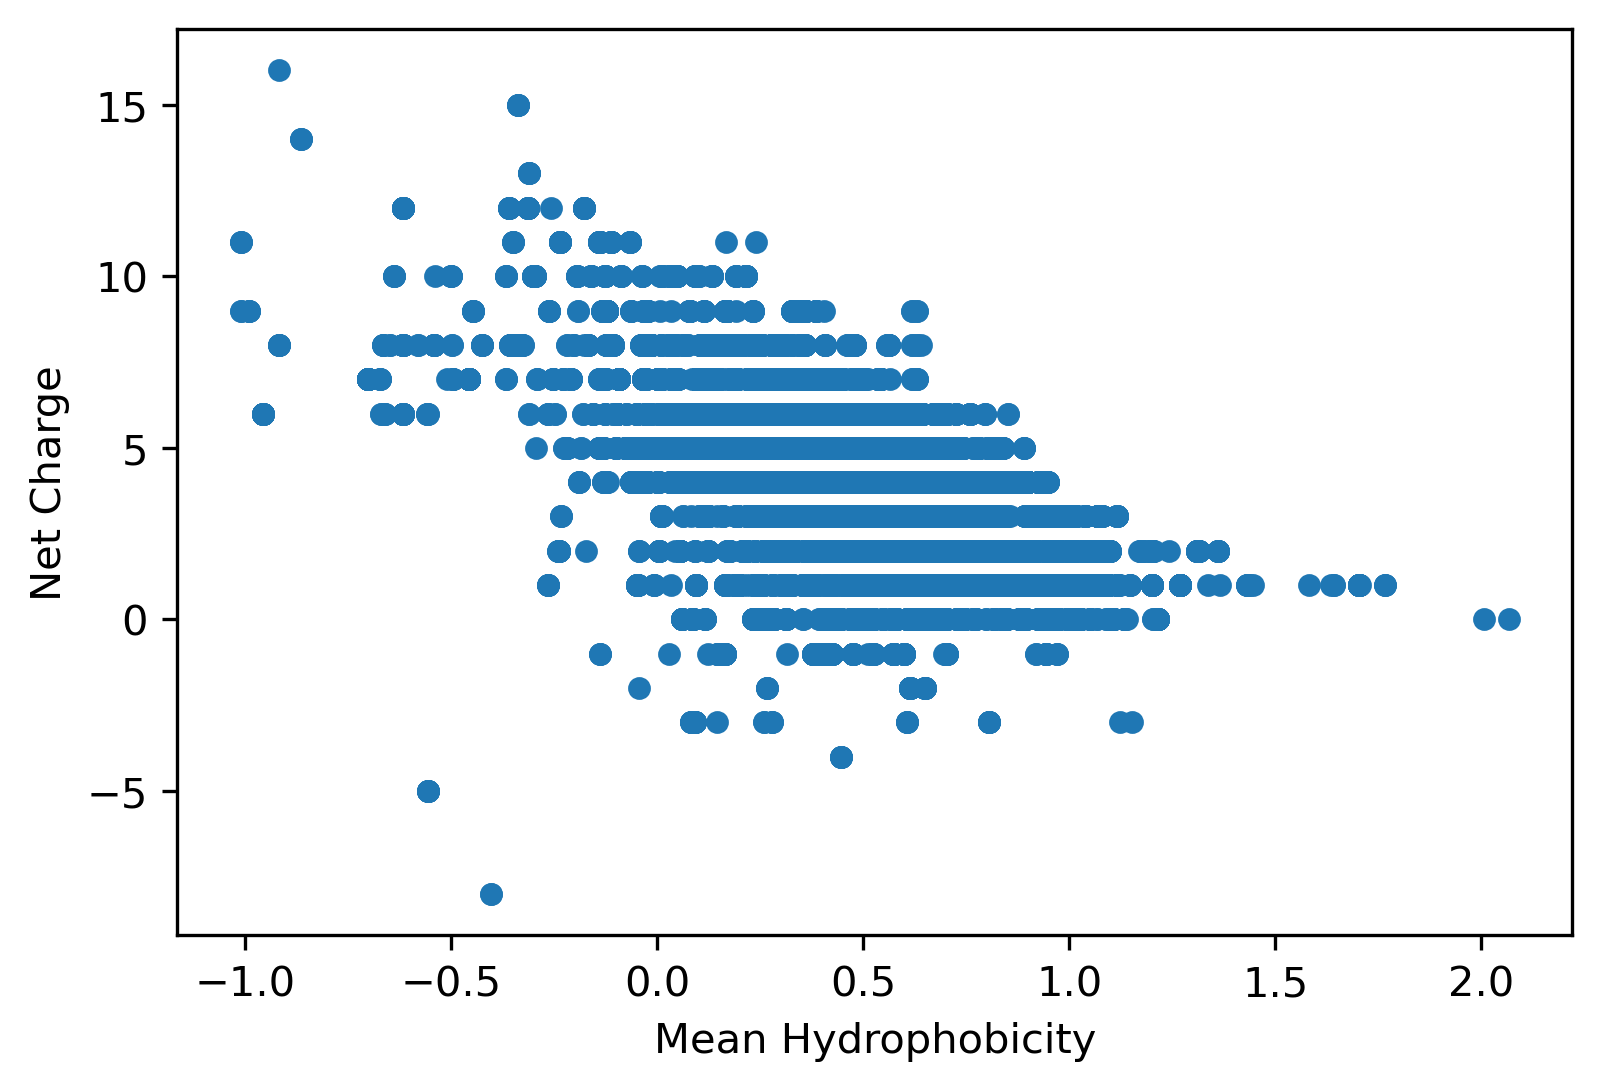

In [18]:
ax = ampDF.plot.scatter(x="MeanHydp", y="NetChrg")
ax.set_xlabel("Mean Hydrophobicity")
ax.set_ylabel("Net Charge")


As expected, there is an inverse relationship between net charge and hydrophobicity. Most AMPs act by entering and disturbing the cellular membrane, therefore having some level of hydrophobicity is important for their function. However, they need to interact with negatively charged lipids and carbohydrates that surround the membrane, which means that many AMPs also show a net positive charge.

To facilitate our analysis, we will continue treating the data to make sure all our MIC values are valid, and fall within a reasonable range.

In [19]:
ampDF = ampDF[ampDF.Concentration > 0]
ampDF = ampDF[ampDF.Concentration < 150]
ampDF.shape

(18889, 10)

The reduction in observations shows us that many values were either probably mis-labelled or outliers. They may be interesting observations for future studies, but would make the current analysis harder.

## Select microbial target

AMPs can target a variety of microbial species, but they often show different patterns of activity against different bacteria. Therefore, we will focus on one target at a time, and will start with the atrget for which we have the most data. We will first find the bacteria for which we have the most MIC values:

In [20]:
tragtTypes = []

# Create a list pairing each microbial target with the number of available MIC values in the database.
for trgt in set(list(ampDF.Target.values)):
    tragtTypes.append( (trgt, list(ampDF.Target.values).count(trgt)) )

# Sort the list by number of available MIC values.
tragtTypes.sort(key=lambda x: x[1], reverse=True)

# Show the top candidate
tragtTypes[0]

('Escherichia coli ATCC 25922', 1197)

Here we see that the target 'Escherichia coli ATCC 25922' has 1197 MIC values reported in the database.

In [21]:
ecDF = ampDF[ ampDF.Target == "Escherichia coli ATCC 25922" ]
ecDF.head()

,ID,Name,Sequence,N_Term,C_Term,Target,Concentration,MeanHydp,NetChrg,Len
97,104,NaN,GLRKRLRKFRNKIKEKLKKI,NaN,NaN,Escherichia coli ATCC 25922,4.0,-0.0860,10,20
135,127,"CAP7 (1-20)[F9P,I13P]",GLRKRLRKPRNKPKEKLKKI,NaN,NaN,Escherichia coli ATCC 25922,64.0,-0.1935,10,20
141,128,"CAP7 (1-20)[L6K,I13K]",GLRKRKRKFRNKKKEKLKKI,NaN,NaN,Escherichia coli ATCC 25922,64.0,-0.3600,12,20
147,129,"CAP7 (1-20)[R5A,K16A]",GLRKALRKFRNKIKEALKKI,NaN,NaN,Escherichia coli ATCC 25922,2.0,0.0450,8,20
153,130,CAP7 (1-20)[F9A],GLRKRLRKARNKIKEKLKKI,NaN,NaN,Escherichia coli ATCC 25922,4.0,-0.1600,10,20


We can now explore how the MIC values relate to the peptides' physicochemical properties. 

MIC values are usually calculated over 2-fold dilutions, such as (16, 32, 64, 128) or (25, 50, 100), and so on. We can see these patterns in the plot below with clear lines at some of these values.

Text(0, 0.5, 'MIC (µMols)')

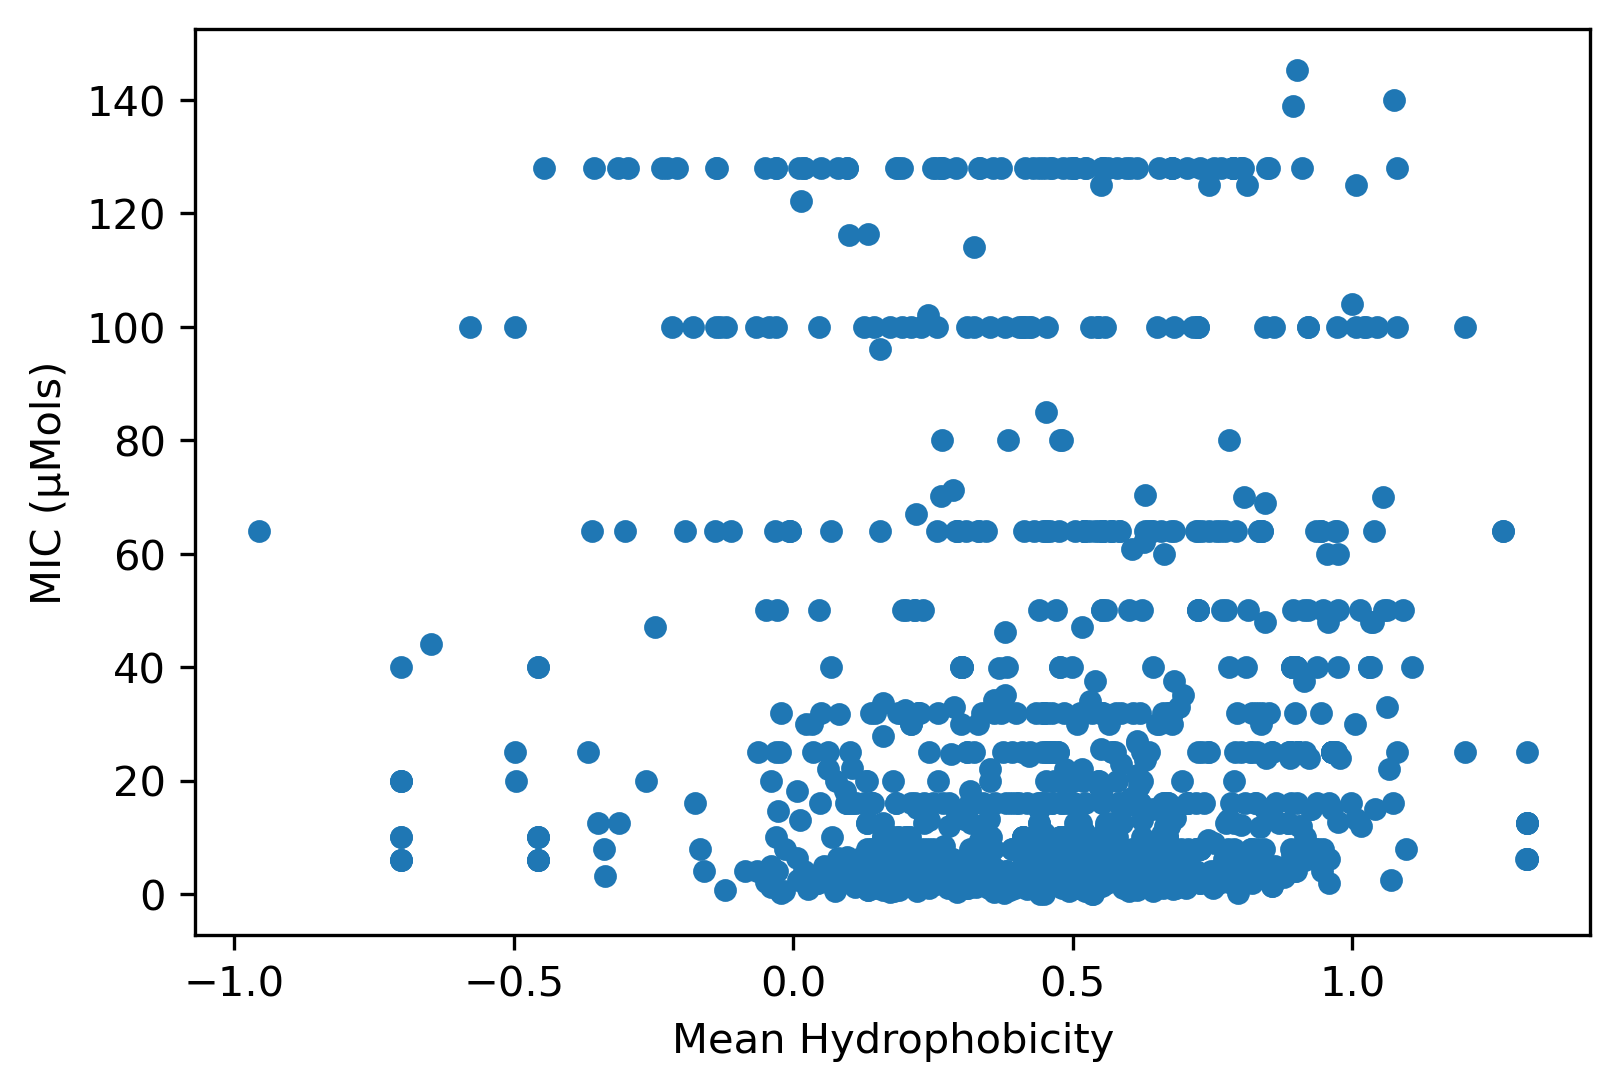

In [22]:
ax = ecDF.plot.scatter(x="MeanHydp", y="Concentration", )
ax.set_xlabel("Mean Hydrophobicity")
ax.set_ylabel("MIC (µMols)")

Text(0, 0.5, 'MIC (µMols)')

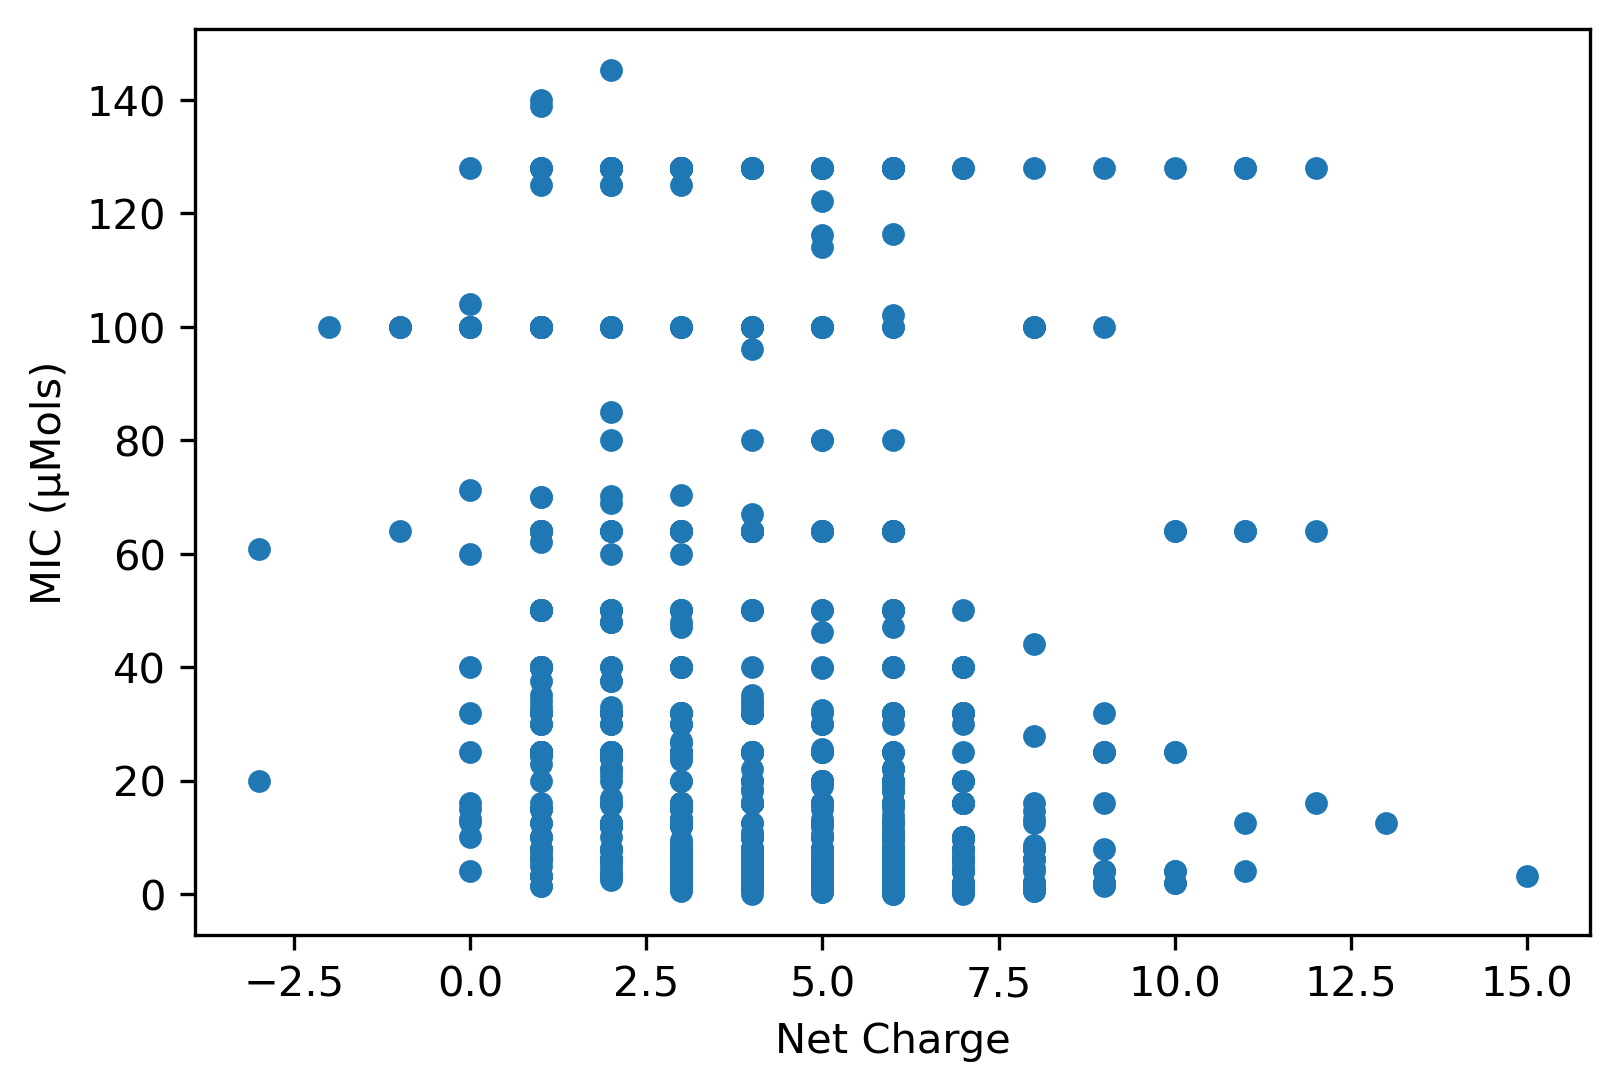

In [23]:
ax = ecDF.plot.scatter(x="NetChrg", y="Concentration", )
ax.set_xlabel("Net Charge")
ax.set_ylabel("MIC (µMols)")

## Prepare data representation

We can now use a bit of Python code to translate the sequence of letters that represent each peptide into a series of vectors that encode physicochemical characteristics of each residue.

In this case, we will be using the [PotFP](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-5-41) scale to describe natural amino acid residues.

In [24]:
# Load peptide encoding object
pepRep = PepEncode(pathToScale="./Datasets/")

In [60]:
# Here is what a numeric representation of the peptide looks like
pepRep.encode("AGRW")

array([[-0.1 , -5.7 , -2.79,  7.33],
       [-4.94, -8.72,  6.6 ,  4.55],
       [-2.13,  4.18,  1.21,  2.77],
       [ 1.7 , -1.35,  2.07, -2.41],
       [-0.39, -0.31,  1.67, -1.08],
       [ 1.06,  2.91,  0.76,  1.04],
       [-1.39,  0.32,  0.  ,  0.23],
       [ 0.97, -0.11,  0.32,  0.59]])

As we can see, this scale has projected each amino acid onto an 8-dimensional space.

We will further trim our targeted dataset to only focus on peptides with no N-terminal modifications, and with the standard amidation in the C-terminal residue.

In [26]:
ecDF = ecDF[ ecDF.N_Term.isna() ]

ecDF = ecDF[ ecDF.C_Term == "AMD" ]

ecDF.shape

(797, 10)

We can now run a final sanity check to make sure our dataset is ready to be used to train models. The most basic element is to make sure there are no duplicates in the data set, and so we can check how many times each amino acid sequence appears in our DataFrame:

In [27]:
seqCount = []

# Create a list pairing each microbial target with the number of available MIC values in the database.
for seq in set(list(ecDF.Sequence.values)):
    seqCount.append( (seq, list(ecDF.Sequence.values).count(seq)) )

# Sort the list by number of available MIC values.
seqCount.sort(key=lambda x: x[1], reverse=True)

# Show the top candidate
seqCount[0:10]

[('CASYFCRWWWLL', 2),
 ('RGGRLCYCRRRFCVCVGR', 2),
 ('CGIIAGIIIKIKKC', 2),
 ('IWRIFRRIFRIFIRF', 1),
 ('RWKKIGWVWKWI', 1),
 ('WWWLRKIW', 1),
 ('RLGTALPALLKTLLAGLNG', 1),
 ('RWYRRWYRRWYR', 1),
 ('GIKAGIIIKIKK', 1),
 ('GSLHGFMYRYLKNMVLNLF', 1)]

It seems that three sequences have duplicate entries, and just by checking the data we have downloaded, it is not clear why that would be. 

In [28]:
ecDF[ ecDF.Sequence == "CASYFCRWWWLL"]

,ID,Name,Sequence,N_Term,C_Term,Target,Concentration,MeanHydp,NetChrg,Len
19668,16900,NaN,CASYFCRWWWLL,NaN,AMD,Escherichia coli ATCC 25922,64.0,1.27,1,12
19700,16902,NaN,CASYFCRWWWLL,NaN,AMD,Escherichia coli ATCC 25922,64.0,1.27,1,12


Going into DBAASP and checking both IDs, we can find that the entry with ID 16900 had an intrachain bond, which could affect its antiomicrobial activity. In our case, for the target "Escherichia coli ATCC 25922", the intrachain bond makes no difference. Still, we will arbitrarily choose to keep the first entry of each pair.

In [29]:
ecDF.drop_duplicates(subset="Sequence", keep="first", inplace=True, )
ecDF.shape

(794, 10)

This leaves us with 794 smaples, which we will now encode using ProtFP.

In [30]:
encodedSeqs = []

for Seq in ecDF.Sequence:
    # Encode each sequence using only the first 3 components of ProtFP.
    encodedSeqs.append( pepRep.encode(Seq)[0:3,:] )

Since we have a variety of sequence lengths, leading to a range of representation sizes, we will padd each representation with zeros in order to get a consistent matrix shape for all samples.

In [31]:
# Find longest peptide 
maxLen = ecDF.Len.max()

# Iterate over all peptides and complete each representation
for indx, fpencode in enumerate(encodedSeqs):
    
    if fpencode.shape[1] < maxLen:
        
        # Creates a zero-padding matrix.
        padding = np.zeros([fpencode.shape[0], (maxLen - fpencode.shape[1])])
        
        # Concatenates to peptide representation and replaces old representation
        encodedSeqs[indx] = np.concatenate( [fpencode, padding], axis=1)

In [32]:
# Now we can transform all representations in a single NumPy array.
encodedSeqs = np.asarray(encodedSeqs)

In [33]:
# And subsequently flatten each matrix into a vector to facilitate data entry for out models.
encodedSeqsFlat = [ fpencode.flatten() for fpencode in encodedSeqs]

As a first data exploration step, we can try to visualize this data. Going from a 3x20 matrix (60-dimensional representation) to a 2D plot cna be challenging, as we will see:

In [34]:
# Load the tSNE class
from sklearn.manifold import TSNE

# Initialize the tSNE object and directs it to project the data onto a 2D space. 
# Warning! The "n_iter_without_progress" was reduced to avoid a very long processing time.
tsneObj = TSNE(n_components=2, n_iter=2000, n_iter_without_progress=100, random_state=12345)

# In this case, the fit_transform method optimizes the distances of nearby points in the reduced 2D space.
pepTSNE = tsneObj.fit_transform(encodedSeqsFlat)

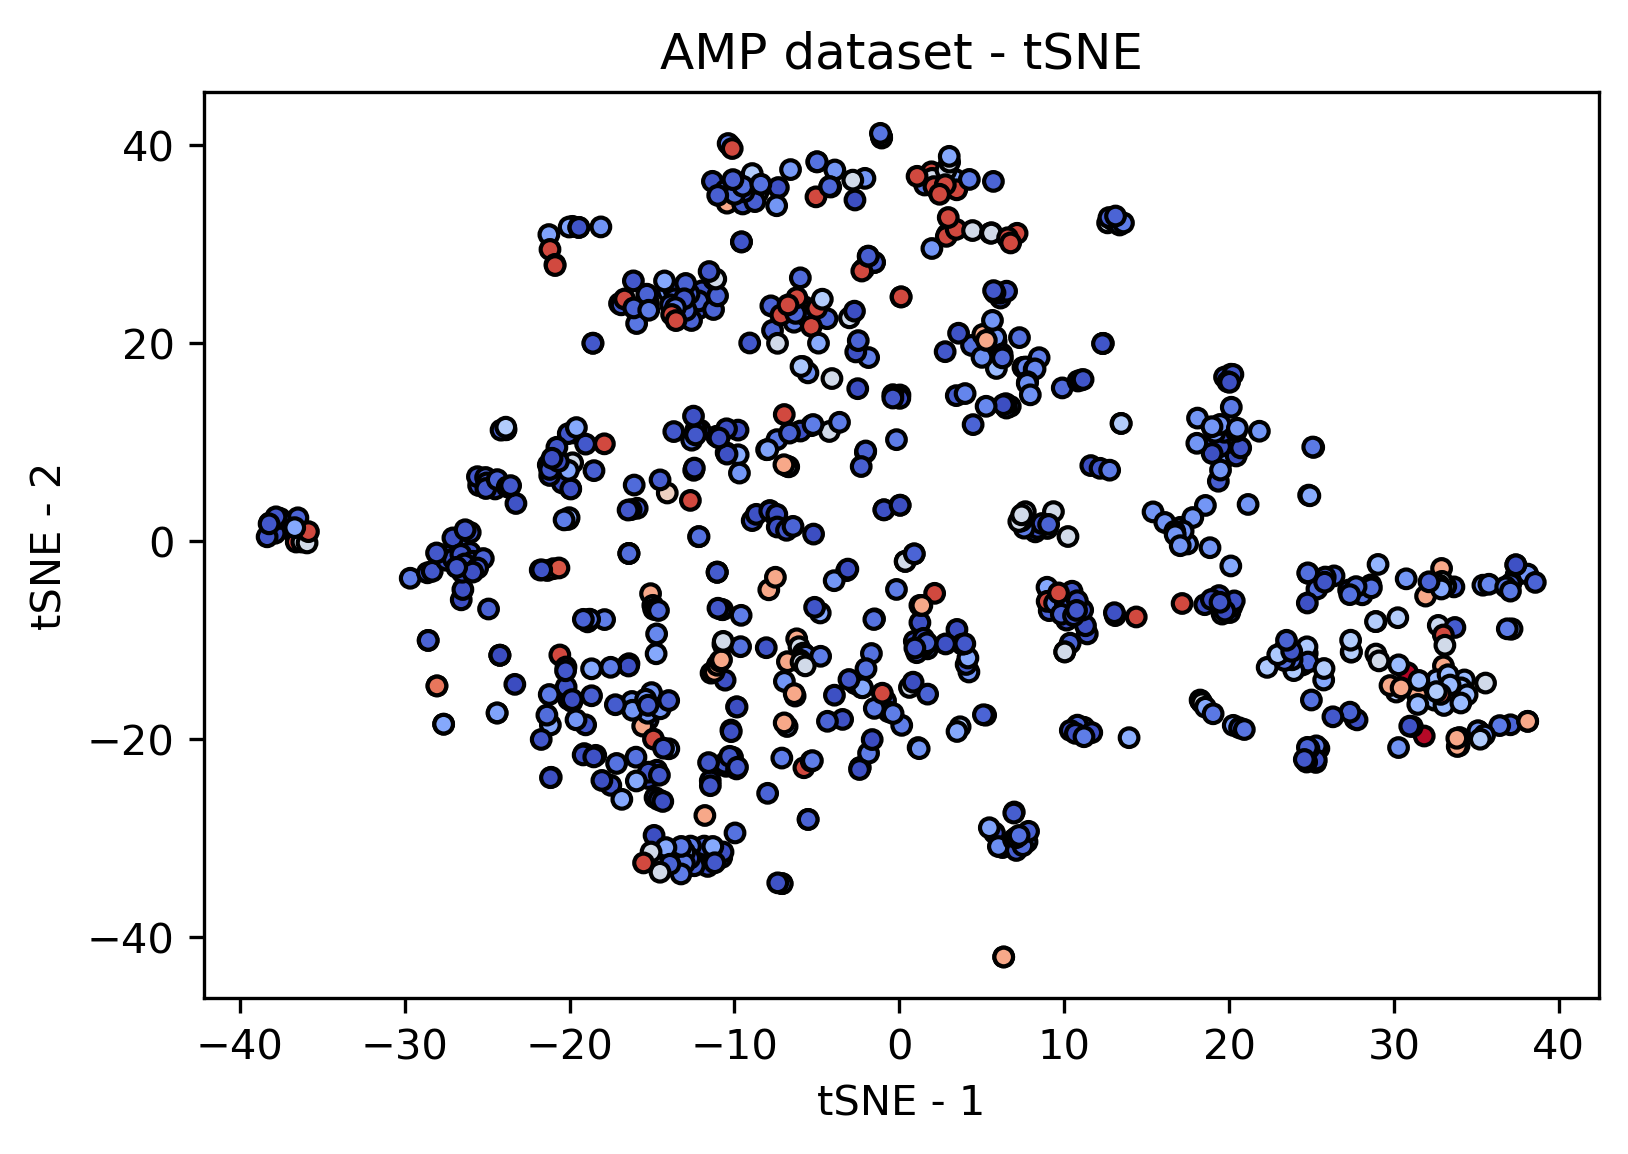

In [35]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pepTSNE[:,0], pepTSNE[:,1],  
            c= ecDF.Concentration.values, cmap=plt.cm.coolwarm, edgecolor='k', s=20)

# Set figure title
ax.set_title('AMP dataset - tSNE')
ax.set_xlabel('tSNE - 1')
ax.set_ylabel('tSNE - 2')

plt.show()

In [36]:
# Load the MDS class
from sklearn.manifold import MDS

# Initialize the MDS object and directs it to project the data onto a 2D space. 
mdsObj = MDS(n_components=2, max_iter=100, n_init=1, random_state=12345)

# In this case, the fit_transform method optimizes the distances of nearby points in the reduced 2D space.
pepMDS = mdsObj.fit_transform(encodedSeqsFlat)

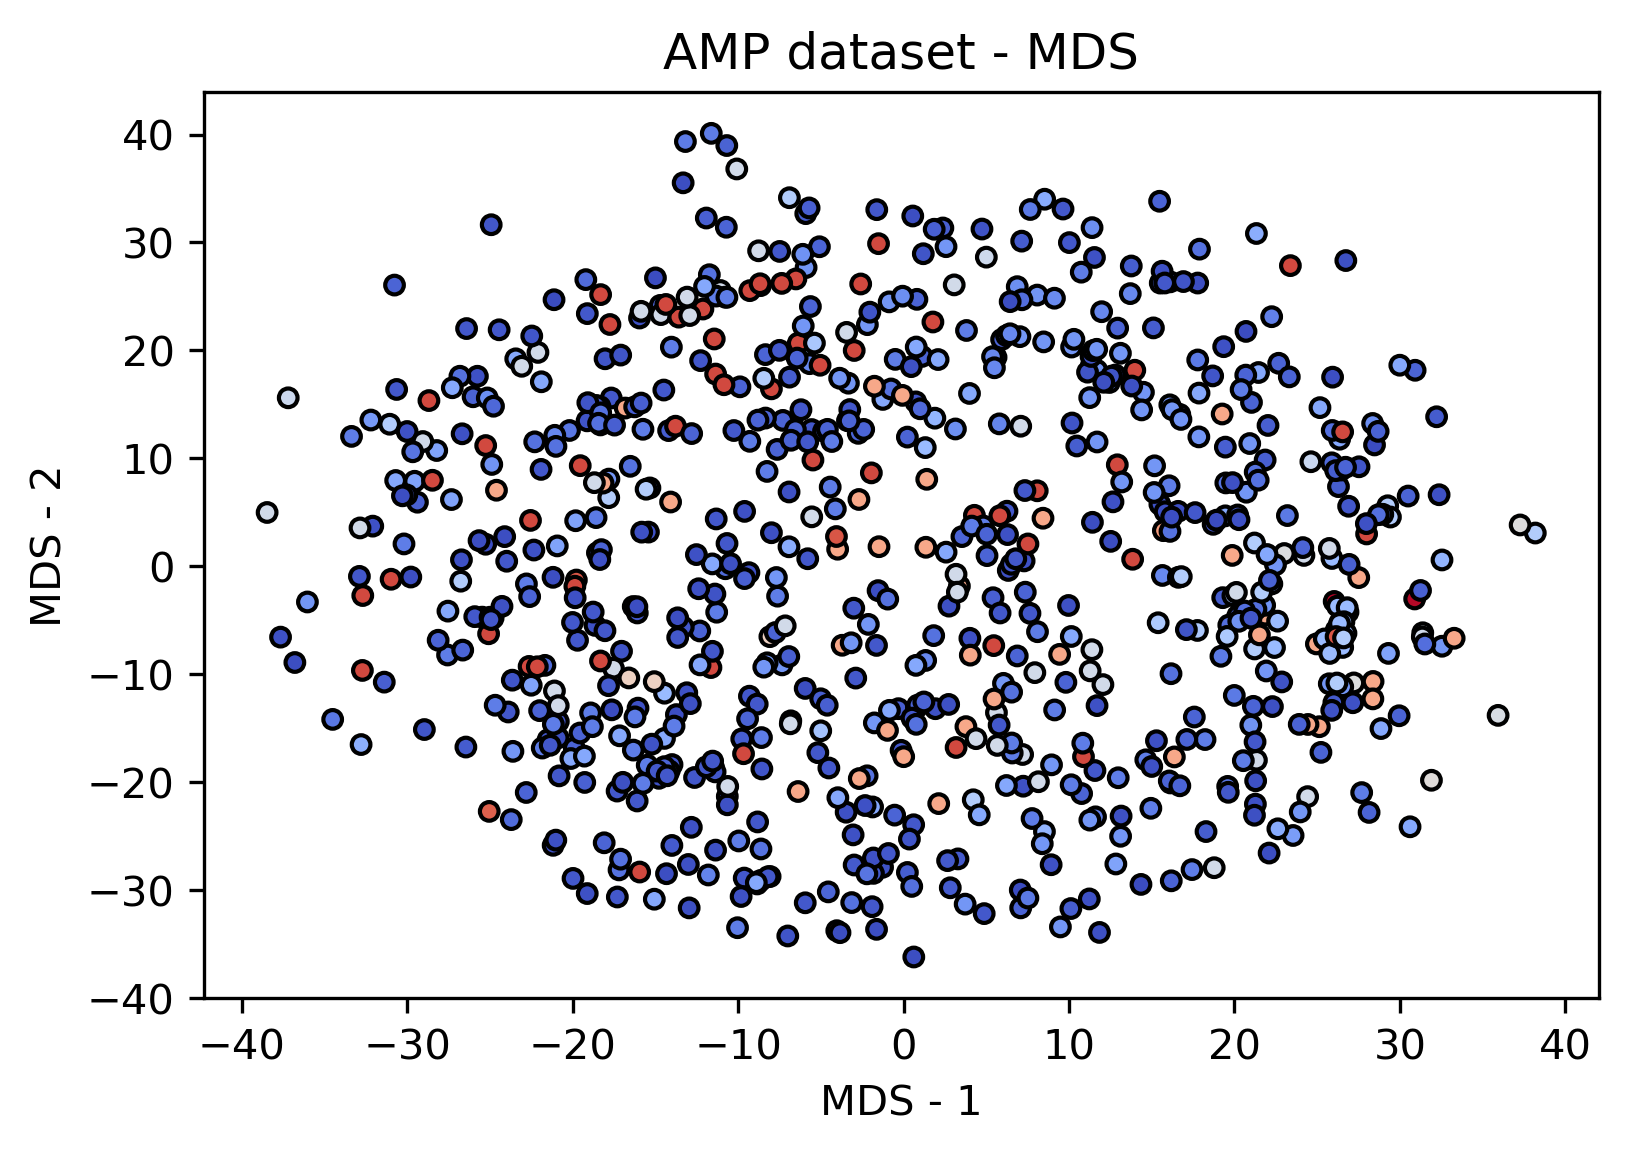

In [61]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pepMDS[:,0], pepMDS[:,1],  
            c= ecDF.Concentration.values, cmap=plt.cm.coolwarm, edgecolor='k', s=20)

# Set figure title
ax.set_title('AMP dataset - MDS')
ax.set_xlabel('MDS - 1')
ax.set_ylabel('MDS - 2')

plt.show()

No clear patter emerges to separate active and inactive peptides, that is, those with low MICs and high MICs.

### Prepare data for training and testing

Since our target values are MICs, which are tested using 2-fold dillutions, we will log tansform the target values to bring them to a linear scale:

In [38]:
targetLog2 = np.log2(ecDF.Concentration.values)

As with any other ML task, we will split our dataset to have disjoint sets of observations for model training and testing. We choose to keep 20% for testing.

In [39]:
from sklearn.model_selection import train_test_split

pep_X_train, pep_X_test, pep_y_train, pep_y_test = train_test_split(
    encodedSeqsFlat, targetLog2, test_size=0.2, random_state=12345)

For the simplest possible approach, we can try a linear regression model trained on all training data, and then tested on the 159 samples we kept for testing.

In [40]:
from sklearn import linear_model

# The LinearRegression functions creates a model object that provides training and prediction capabilities.
regr = linear_model.LinearRegression()

# The fit method is used to train the Linear Regression model. 
# Here we are using the 80% split of the data set that was dedicated for trainig.
regr.fit(pep_X_train, pep_y_train)

# Using the trained model, we can now make predictions. 
# We now use the 20% of the data set that was not used to train the model.
pep_y_pred = regr.predict(pep_X_test)

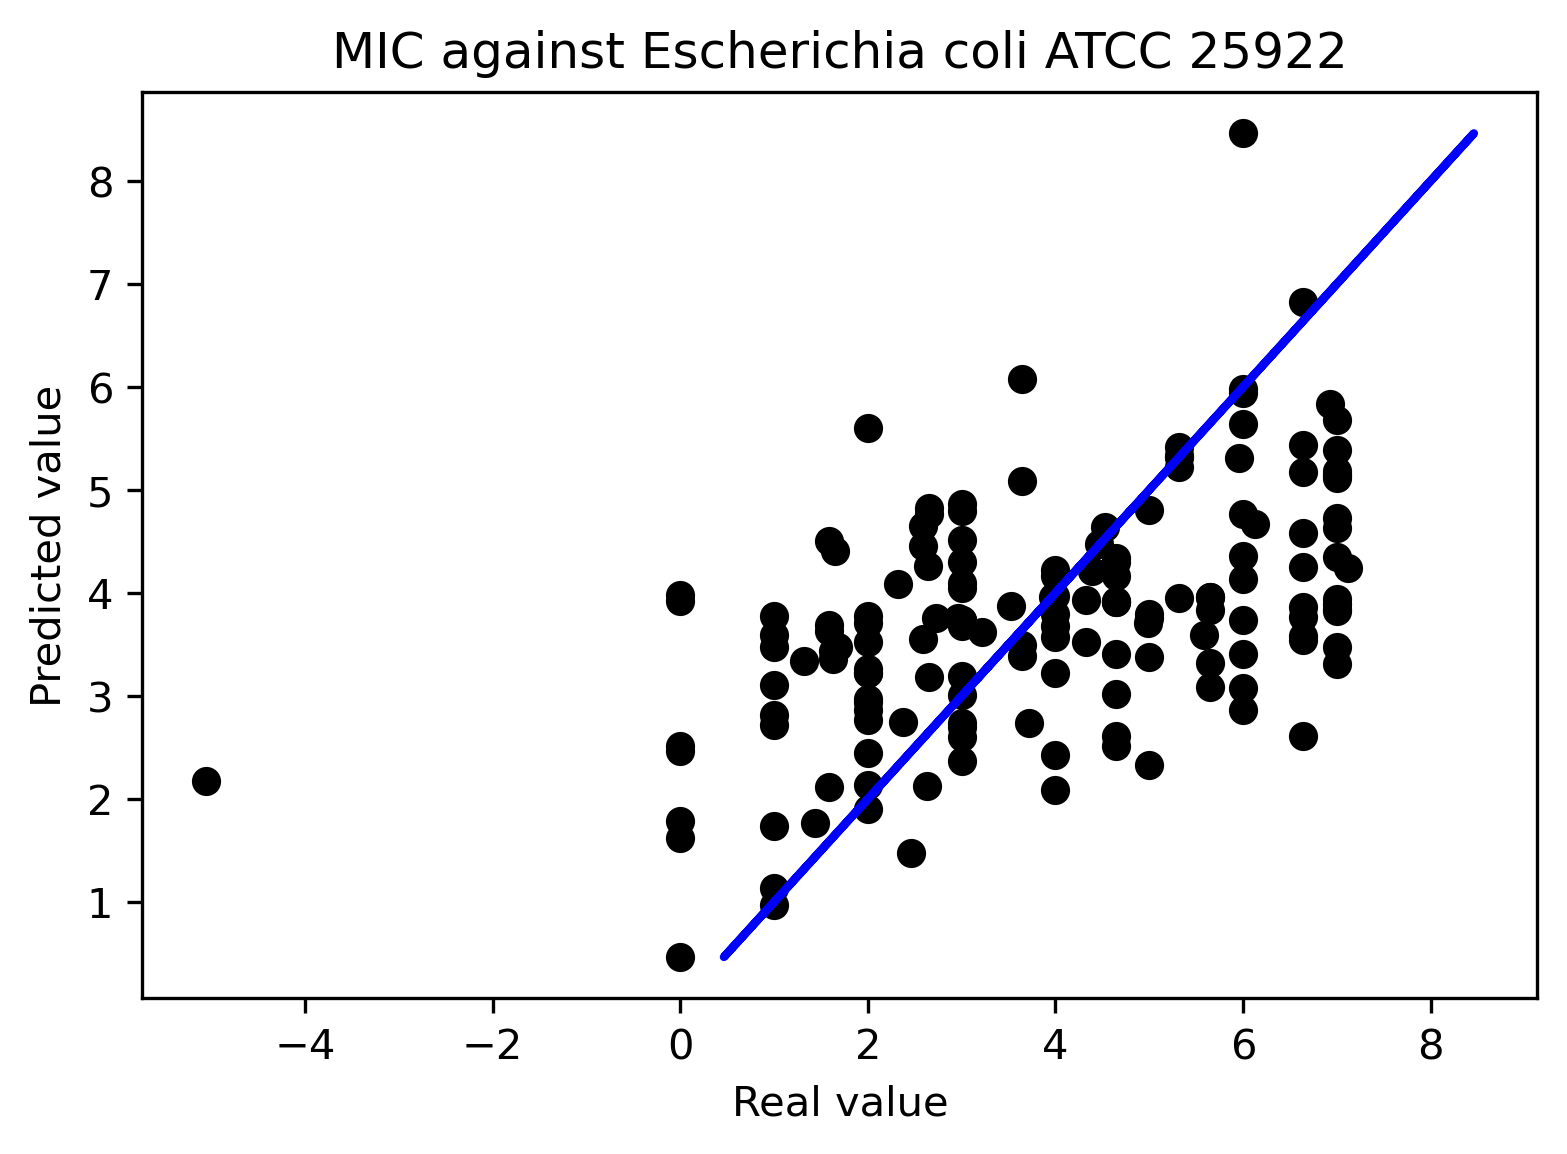

In [41]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pep_y_test, pep_y_pred,  color='black')
plt.plot(pep_y_pred, pep_y_pred, color='blue', linewidth=2)

# Set figure title
ax.set_title('MIC against Escherichia coli ATCC 25922')
ax.set_xlabel('Real value')
ax.set_ylabel('Predicted value')

plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error as maeScore

resultPearsonR = sp.stats.pearsonr(pep_y_test, pep_y_pred)
print("Pearson correlation coefficient: {}".format(round(resultPearsonR[0],3)))
print("P-value for non-correlation: {}".format(resultPearsonR[1]))

resultMAE = maeScore(pep_y_test, pep_y_pred)
print("Mean absolute error: {}".format(round(resultMAE,3)))

Pearson correlation coefficient: 0.525
P-value for non-correlation: 1.2376607591662081e-12
Mean absolute error: 1.469


Clearly, with a correlation of 0.52, this is far from an excellent model, but given the complexity of the data, the results is quite surprising.
Now we can try a series of more complex models to try to find a good regression fit.

### SVM - Linear kernel

In [43]:
# Load necessary libraries 
from sklearn.svm import LinearSVR, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Initialize pipeline
svr = make_pipeline(StandardScaler(),
                    LinearSVR(random_state=0, tol=1e-5, max_iter=2000))

# Train model
svr.fit(pep_X_train, pep_y_train)

# Predict values
pep_y_pred = svr.predict(pep_X_test)

/home/melomcr/anaconda3/envs/ML_Env/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


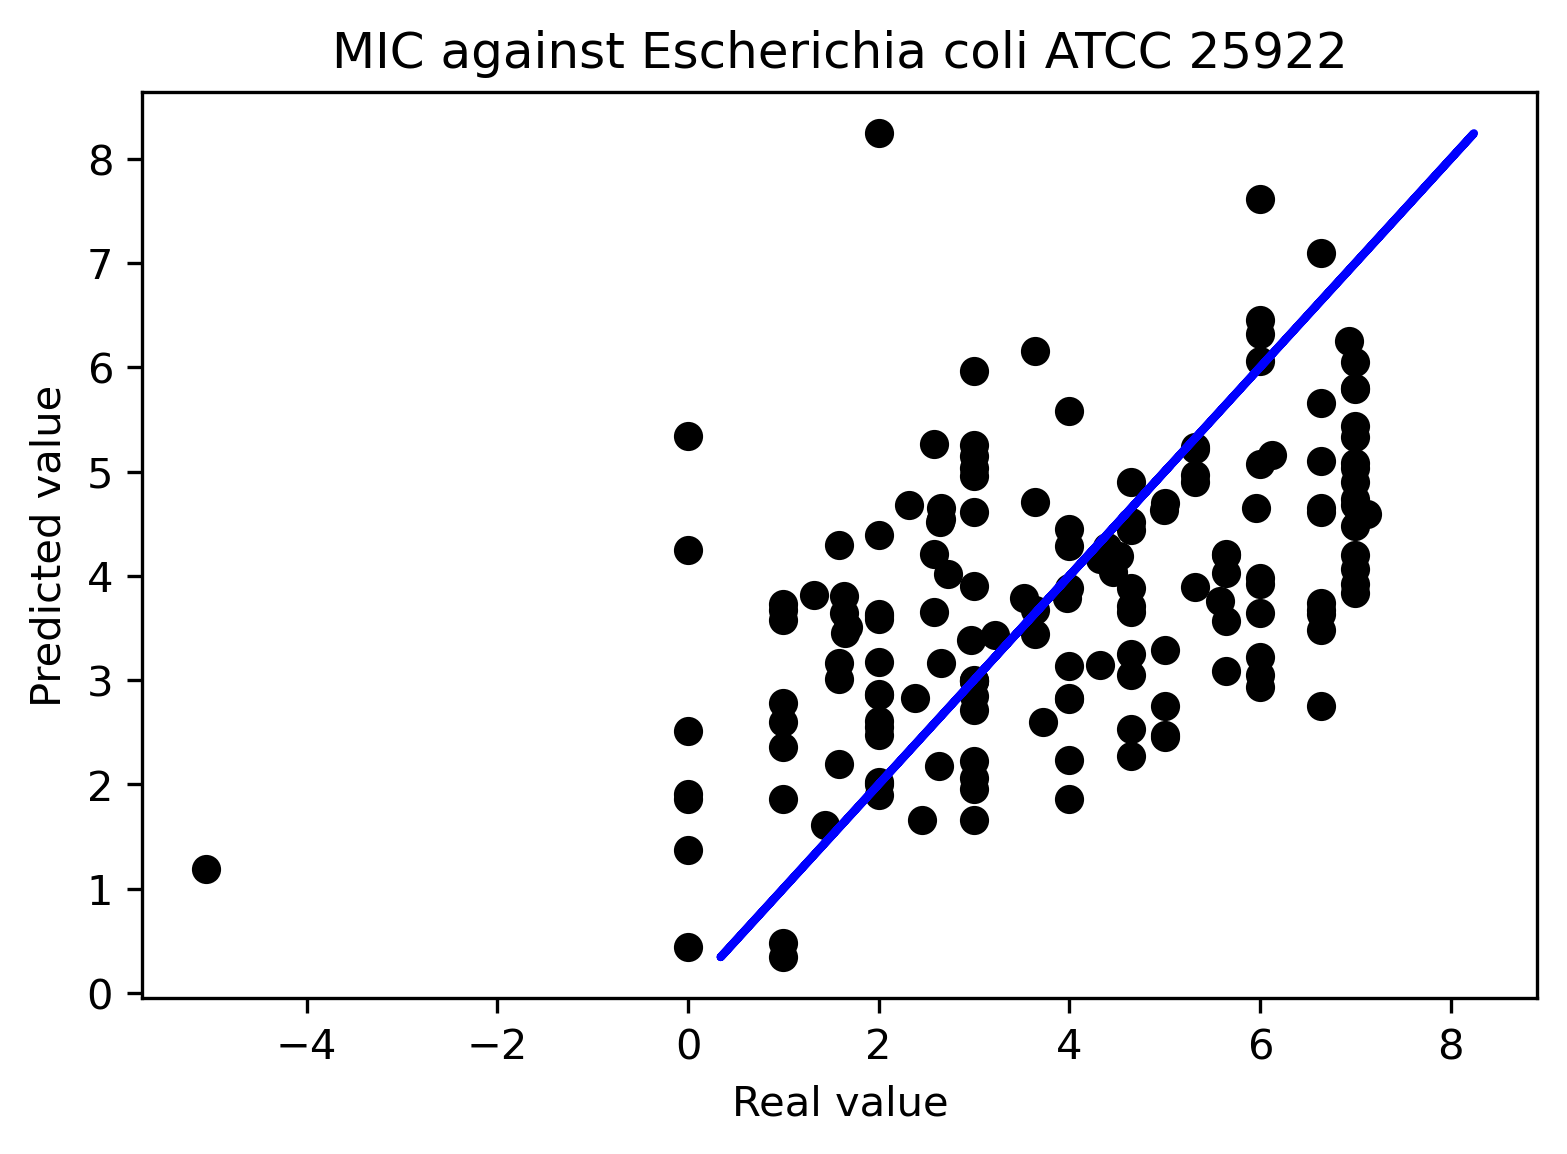

In [44]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pep_y_test, pep_y_pred,  color='black')
plt.plot(pep_y_pred, pep_y_pred, color='blue', linewidth=2)

# Set figure title
ax.set_title('MIC against Escherichia coli ATCC 25922')
ax.set_xlabel('Real value')
ax.set_ylabel('Predicted value')

plt.show()

In [45]:
resultPearsonR = sp.stats.pearsonr(pep_y_test, pep_y_pred)
print("Pearson correlation coefficient: {}".format(round(resultPearsonR[0],3)))
print("P-value for non-correlation: {}".format(resultPearsonR[1]))

resultMAE = maeScore(pep_y_test, pep_y_pred)
print("Mean absolute error: {}".format(round(resultMAE,3)))

Pearson correlation coefficient: 0.507
P-value for non-correlation: 8.825982796816674e-12
Mean absolute error: 1.505


### SVM - RBF kernel

In [46]:
# Initialize pipeline
svr = make_pipeline(StandardScaler(),
                    SVR(kernel="rbf", degree=2, tol=1e-5))

# Train model
svr.fit(pep_X_train, pep_y_train)

# Predict values
pep_y_pred = svr.predict(pep_X_test)

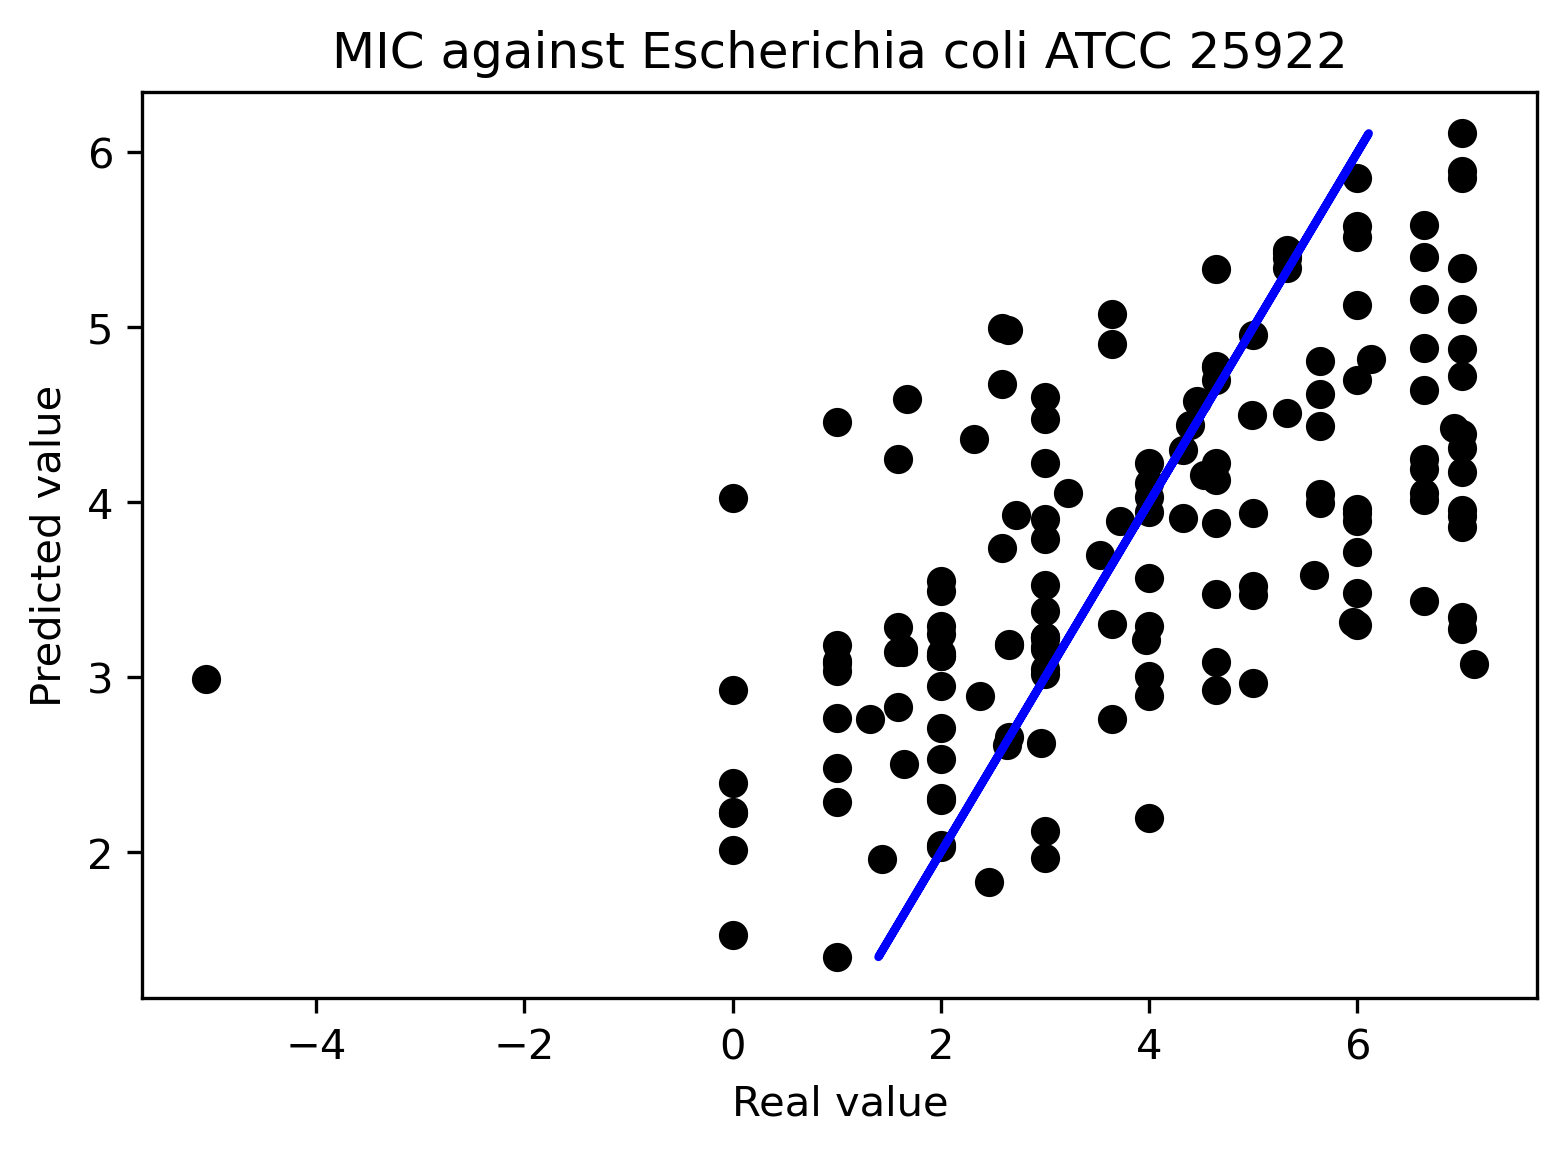

In [47]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pep_y_test, pep_y_pred,  color='black')
plt.plot(pep_y_pred, pep_y_pred, color='blue', linewidth=2)

# Set figure title
ax.set_title('MIC against Escherichia coli ATCC 25922')
ax.set_xlabel('Real value')
ax.set_ylabel('Predicted value')

plt.show()

In [48]:
result = sp.stats.pearsonr(pep_y_test, pep_y_pred)
print("Pearson correlation coefficient: {}".format(round(result[0],3)))
print("P-value for non-correlation: {}".format(result[1]))

Pearson correlation coefficient: 0.616
P-value for non-correlation: 5.884076489502069e-18


### AdaBoost

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Initialize regressor
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), loss="linear",
                          n_estimators=50, random_state=12345)

# Train model
abr.fit(pep_X_train, pep_y_train)

# Predict values
pep_y_pred = abr.predict(pep_X_test)

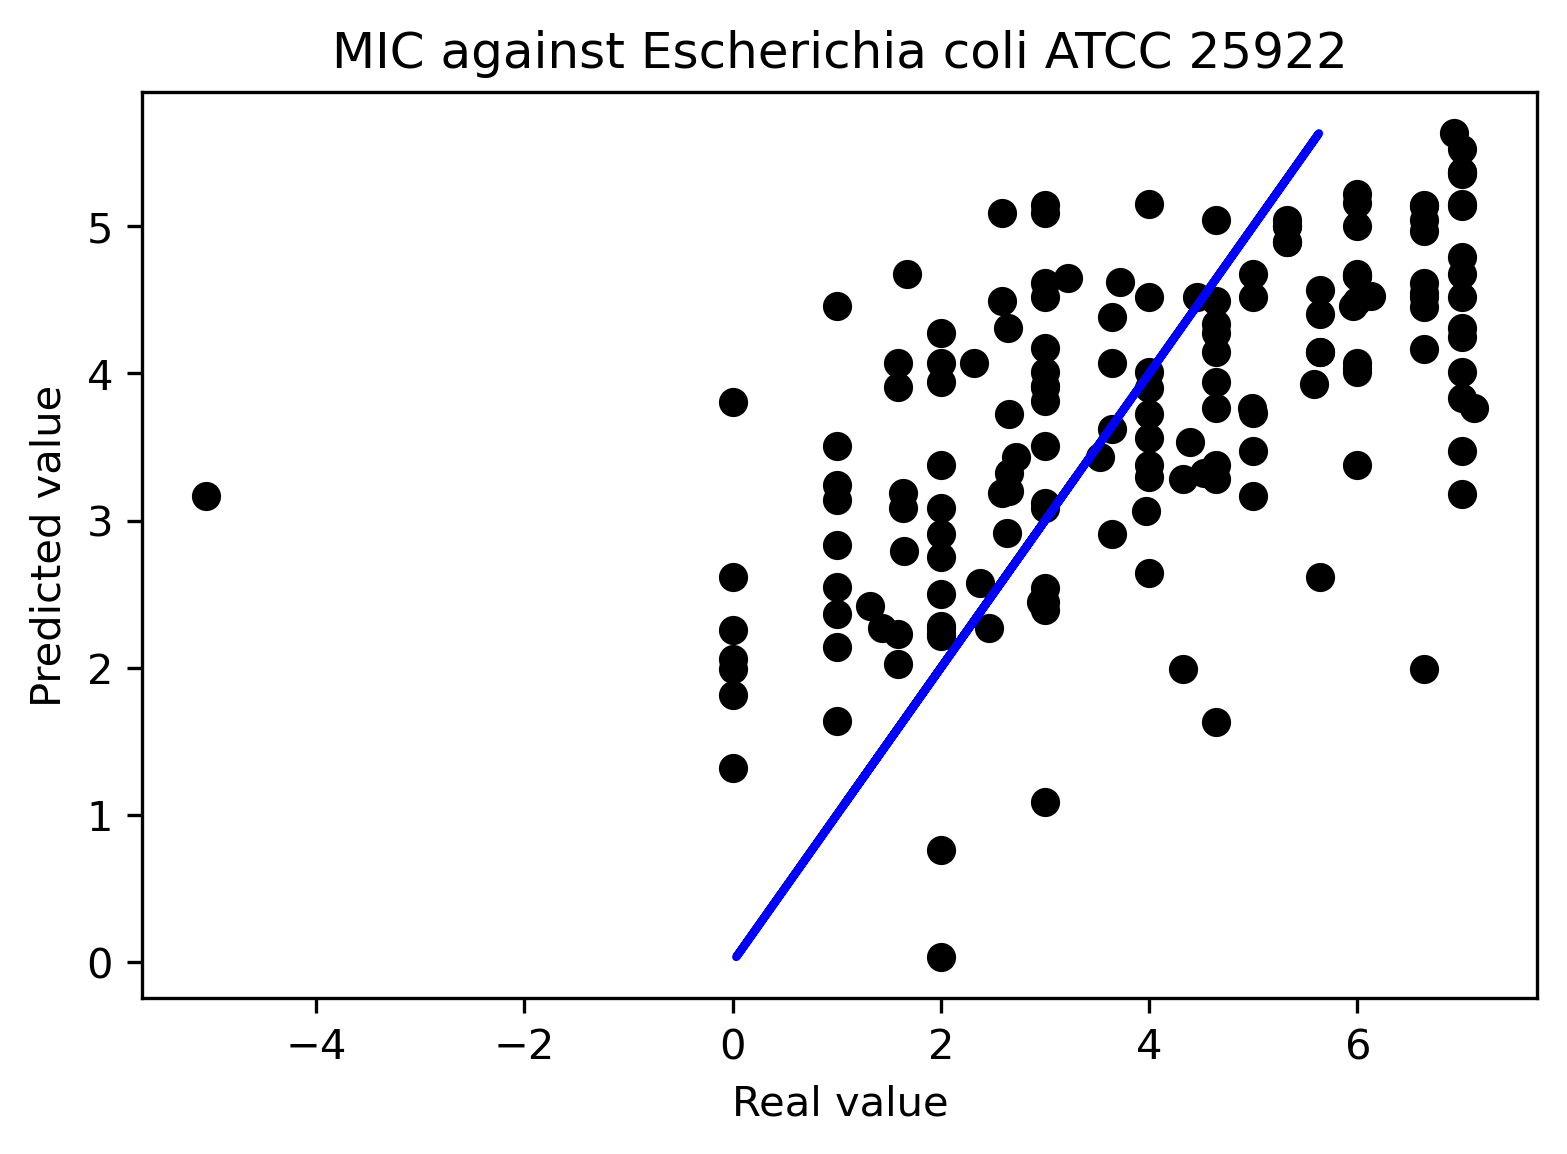

In [50]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pep_y_test, pep_y_pred,  color='black')
plt.plot(pep_y_pred, pep_y_pred, color='blue', linewidth=2)

# Set figure title
ax.set_title('MIC against Escherichia coli ATCC 25922')
ax.set_xlabel('Real value')
ax.set_ylabel('Predicted value')

plt.show()

In [51]:
resultPearsonR = sp.stats.pearsonr(pep_y_test, pep_y_pred)
print("Pearson correlation coefficient: {}".format(round(resultPearsonR[0],3)))
print("P-value for non-correlation: {}".format(resultPearsonR[1]))

resultMAE = maeScore(pep_y_test, pep_y_pred)
print("Mean absolute error: {}".format(round(resultMAE,3)))

Pearson correlation coefficient: 0.588
P-value for non-correlation: 3.5213664642773944e-16
Mean absolute error: 1.419


### Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Initialize regressor
rfr = RandomForestRegressor(n_estimators=50, random_state=12345)

# Train model
rfr.fit(pep_X_train, pep_y_train)

# Predict values
pep_y_pred = rfr.predict(pep_X_test)

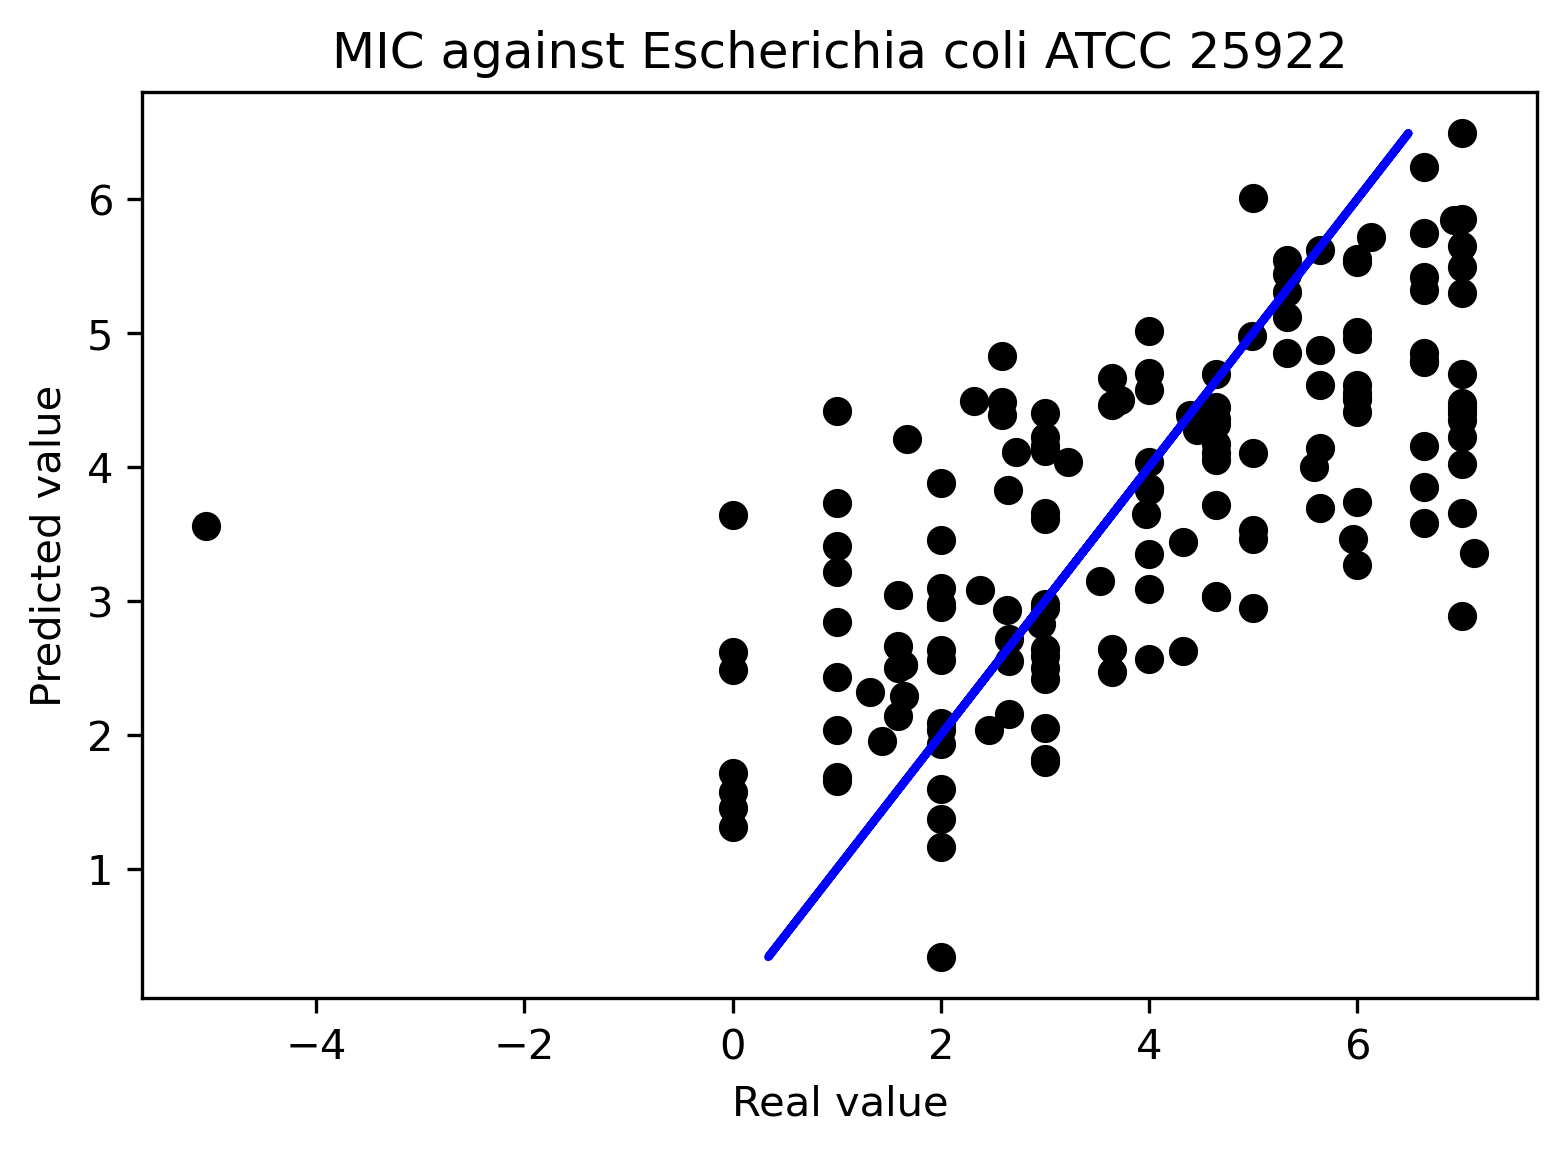

In [53]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pep_y_test, pep_y_pred,  color='black')
plt.plot(pep_y_pred, pep_y_pred, color='blue', linewidth=2)

# Set figure title
ax.set_title('MIC against Escherichia coli ATCC 25922')
ax.set_xlabel('Real value')
ax.set_ylabel('Predicted value')

plt.show()

In [54]:
resultPearsonR = sp.stats.pearsonr(pep_y_test, pep_y_pred)
print("Pearson correlation coefficient: {}".format(round(resultPearsonR[0],3)))
print("P-value for non-correlation: {}".format(resultPearsonR[1]))

resultMAE = maeScore(pep_y_test, pep_y_pred)
print("Mean absolute error: {}".format(round(resultMAE,3)))

Pearson correlation coefficient: 0.664
P-value for non-correlation: 1.3826975133590056e-21
Mean absolute error: 1.251


### Multilayer perceptron

In [55]:
from sklearn.neural_network import MLPRegressor

# Initialize regressor
mlpr = make_pipeline(StandardScaler(),
                    MLPRegressor([200,100], 
                                 activation="tanh", 
                                 random_state=12345, max_iter=1000))
# mlpr = MLPRegressor([100,100], activation="tanh", random_state=12345, max_iter=1000)

# Train model
mlpr.fit(pep_X_train, pep_y_train)

# Predict values
pep_y_pred = mlpr.predict(pep_X_test)

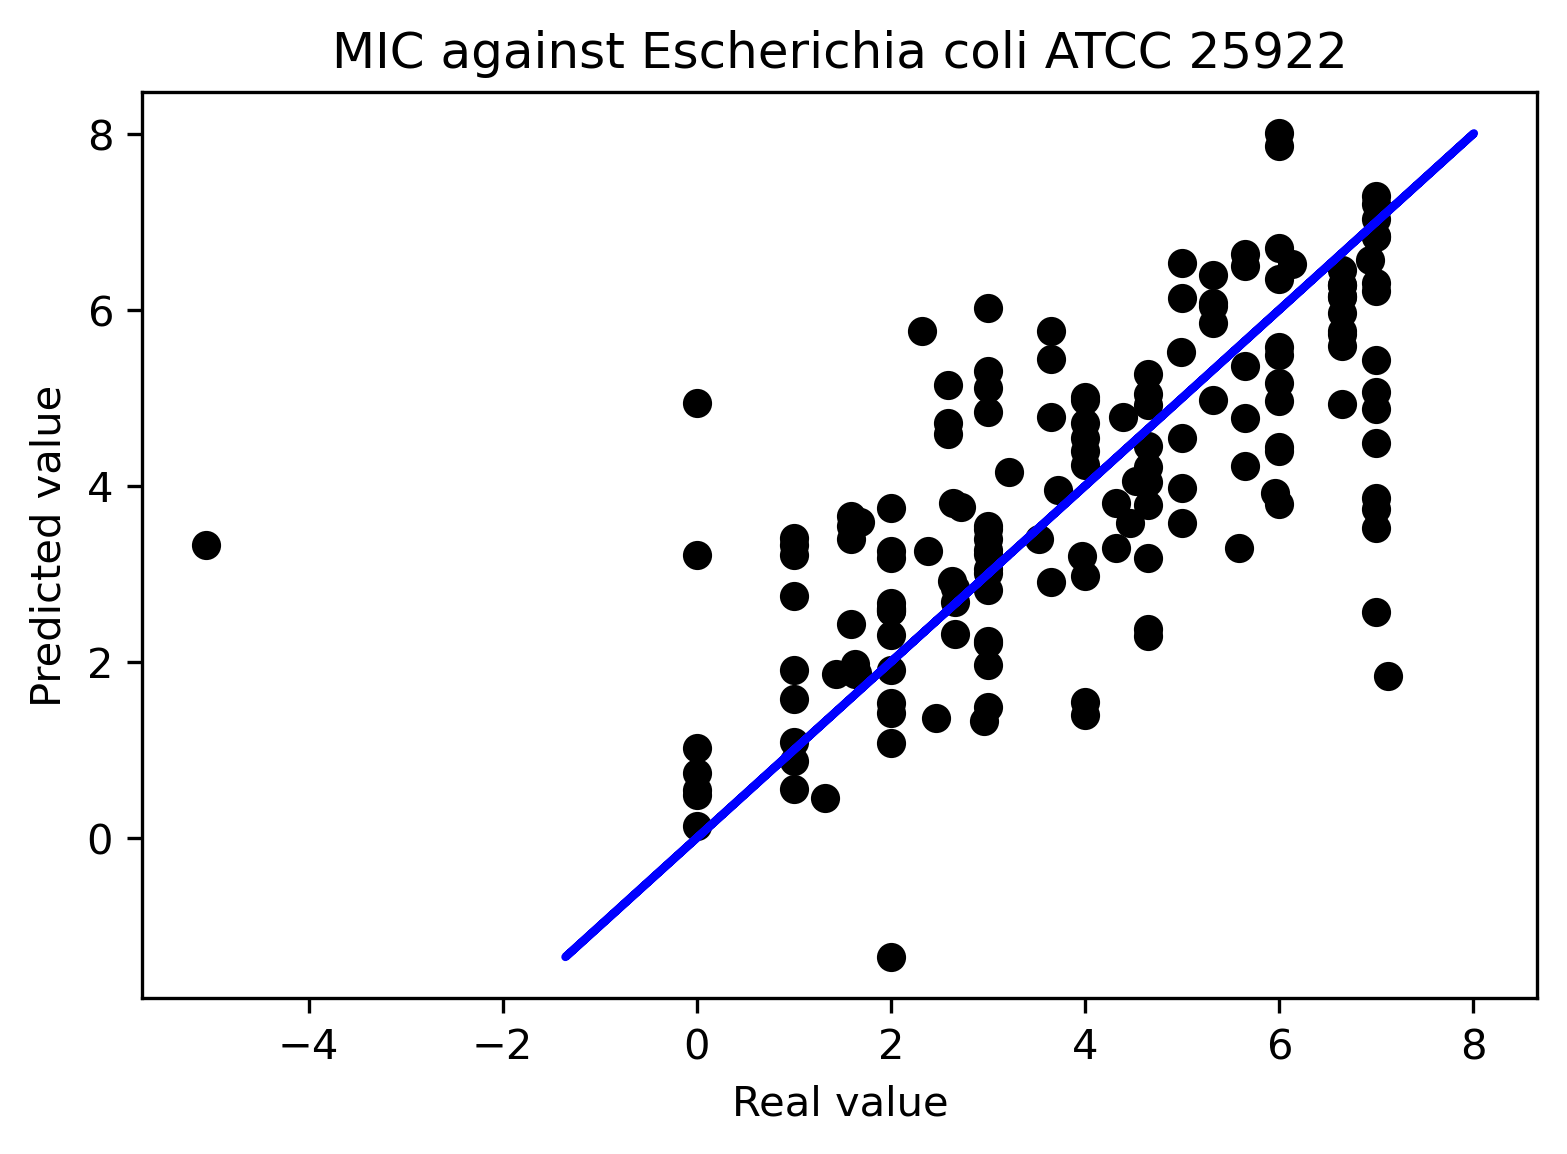

In [56]:
# Initialize figure
fig, ax = plt.subplots()

# Create scatter plot
plt.scatter(pep_y_test, pep_y_pred,  color='black')
plt.plot(pep_y_pred, pep_y_pred, color='blue', linewidth=2)

# Set figure title
ax.set_title('MIC against Escherichia coli ATCC 25922')
ax.set_xlabel('Real value')
ax.set_ylabel('Predicted value')

plt.show()

In [57]:
resultPearsonR = sp.stats.pearsonr(pep_y_test, pep_y_pred)
print("Pearson correlation coefficient: {}".format(round(resultPearsonR[0],3)))
print("P-value for non-correlation: {}".format(resultPearsonR[1]))

resultMAE = maeScore(pep_y_test, pep_y_pred)
print("Mean absolute error: {}".format(round(resultMAE,3)))

Pearson correlation coefficient: 0.676
P-value for non-correlation: 1.3947722832226443e-22
Mean absolute error: 1.172


We see a variety of methods and different Pearson correlation coefficients:
- Linear Regression: 0.525
- SVM Regressor (linear kernel): 0.507
- SVM Regressor (RBF kernel): 0.616
- AdaBoost (boosted tree regressors): 0.588
- Random Forest (bagged tree regressors): 0.664
- Multilayer Perceptron (neural network): 0.676

Using the database information, we could construct training and testing sets used to create a variety of ML models for antimicrobial activity, some with reasonable predictive power. 